### **Nesse projeto iremos desenvolver uma rede neural para classificação de imagens usando o CIFAR-10**


Como desejo usar o Colaborabory vou executar a célula abaixo para poder acessar os arquivos no drive e salvar em uma pasta especifica.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.chdir("drive/My Drive/Colab Notebooks")


**1º Baixar as imagens da base**

In [ ]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2022-08-11 18:27:26--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  32.2MB/s    in 6.1s    

2022-08-11 18:27:33 (26.6 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


2º Importar alguns recursos básicos

In [ ]:
# código de inicialização 

import random
import numpy as np
import matplotlib.pyplot as plt
from past.builtins import xrange

from __future__ import print_function

# Para as figuras geradas pela biblioteca matplotlib aparecerem dentro do notebbok temos que fazer alguns ajustes
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) #ajusta o tamanho
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# também carregamos alguns outros modulos de python externos
%load_ext autoreload
%autoreload 2

3º Carregamento dos dados da CIFAR-10

In [ ]:
from __future__ import print_function

from six.moves import cPickle as pickle
import numpy as np
import os
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

# Carrega os dados brutos da base CIFAR-10.
# Para tanto, você deve ter feito o download de http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Apenas para verificação, vamos exibir o tamanho dos dados de treinamento e teste.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


4º testando os dados gerados

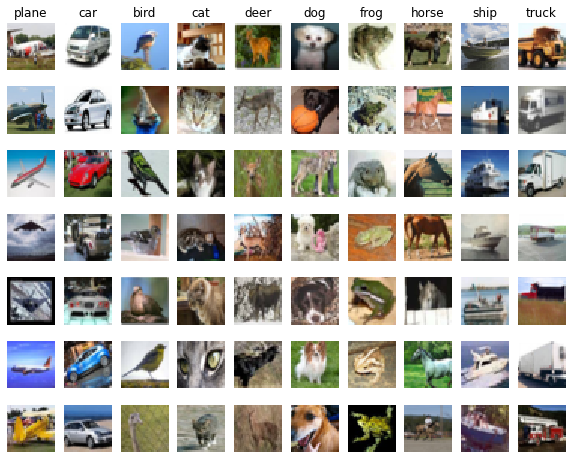

In [ ]:
# Visualizar algumas amostras das 10 classes de imagens da base CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Agora iremos utilizar o classificar KNN, porém antes iremos fazer uma subamostragem para maior eficiencia do treinamneto

In [ ]:
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

#  matrizes são transformadas em vetores
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


Será utilizado a classe `KNearestNeighbor`  para representar instâncias de um classificador *kNN* conforme abaixo

In [ ]:
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in xrange(num_test):
      for j in xrange(num_train):
        dists[i, j] = np.sqrt(np.sum(np.square(self.X_train[j] - X[i])))
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in xrange(num_test):
      dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i,:]), axis = 1))
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    x2 = np.sum(X**2, axis=1).reshape((num_test,1))
    y2 = np.sum(self.X_train**2, axis=1).reshape((1,num_train))
    xy = X.dot(self.X_train.T)
    dists = np.sqrt(x2+y2-2*xy)
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in xrange(num_test):
      closest_y = []
      closest_y = self.y_train[np.argsort(dists[i,:])[:k]]
      y_pred[i] = np.argmax(np.bincount(closest_y))

    return y_pred


classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

Depois desses ajuste será possivel utilizar o classificador KNN em dois passos:

1. Primeiro, deve-se calcular as distâncias entre todas as amostras de teste e todos os dados de treinamento.
2. Dadas essas distâncias, para cada amostra de teste, deve-se encontrar os k exemplos mais próximos entre os dados de treinamento e utilizá-los para uma **votação**, de forma a determinar o rótulo da amostra teste.


In [ ]:
#Primeiro irei experimentar com a função compute distances loops
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


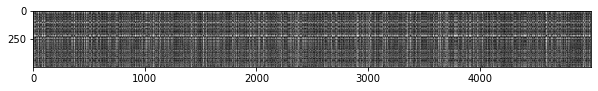

In [ ]:
plt.imshow(dists, interpolation='none')
plt.show()

Com a matriz de distancia calculada é possivel utilizar predições para isso iremos utilizar o predict labels

In [ ]:
#iremos utilizar k=1 
y_test_pred = classifier.predict_labels(dists, k=1)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


## Vamos ver se conseguimos melhorar a eficiencia
Para isso iremos primeiramente duplicar a matriz e fazer a paralelização de um dos laços.

In [ ]:
class KNearestNeighbor(object):
  """ a kNN classifier with L2 distance """

  def __init__(self):
    pass

  def train(self, X, y):
    """
    Train the classifier. For k-nearest neighbors this is just 
    memorizing the training data.

    Inputs:
    - X: A numpy array of shape (num_train, D) containing the training data
      consisting of num_train samples each of dimension D.
    - y: A numpy array of shape (N,) containing the training labels, where
         y[i] is the label for X[i].
    """
    self.X_train = X
    self.y_train = y
    
  def predict(self, X, k=1, num_loops=0):
    """
    Predict labels for test data using this classifier.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data consisting
         of num_test samples each of dimension D.
    - k: The number of nearest neighbors that vote for the predicted labels.
    - num_loops: Determines which implementation to use to compute distances
      between training points and testing points.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    if num_loops == 0:
      dists = self.compute_distances_no_loops(X)
    elif num_loops == 1:
      dists = self.compute_distances_one_loop(X)
    elif num_loops == 2:
      dists = self.compute_distances_two_loops(X)
    else:
      raise ValueError('Invalid value %d for num_loops' % num_loops)

    return self.predict_labels(dists, k=k)

  def compute_distances_two_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a nested loop over both the training data and the 
    test data.

    Inputs:
    - X: A numpy array of shape (num_test, D) containing test data.

    Returns:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      is the Euclidean distance between the ith test point and the jth training
      point.
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in xrange(num_test):
      for j in xrange(num_train):
        dists[i, j] = np.sqrt(np.sum(np.square(self.X_train[j] - X[i])))
    return dists

  def compute_distances_one_loop(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using a single loop over the test data.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train))
    for i in xrange(num_test):
      dists[i, :] = np.sqrt(np.sum(np.square(self.X_train - X[i,:]), axis = 1))
    return dists

  def compute_distances_no_loops(self, X):
    """
    Compute the distance between each test point in X and each training point
    in self.X_train using no explicit loops.

    Input / Output: Same as compute_distances_two_loops
    """
    num_test = X.shape[0]
    num_train = self.X_train.shape[0]
    dists = np.zeros((num_test, num_train)) 
    x2 = np.sum(X**2, axis=1).reshape((num_test,1))
    y2 = np.sum(self.X_train**2, axis=1).reshape((1,num_train))
    xy = X.dot(self.X_train.T)
    dists = np.sqrt(x2+y2-2*xy)
    return dists

  def predict_labels(self, dists, k=1):
    """
    Given a matrix of distances between test points and training points,
    predict a label for each test point.

    Inputs:
    - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
      gives the distance betwen the ith test point and the jth training point.

    Returns:
    - y: A numpy array of shape (num_test,) containing predicted labels for the
      test data, where y[i] is the predicted label for the test point X[i].  
    """
    num_test = dists.shape[0]
    y_pred = np.zeros(num_test)
    for i in xrange(num_test):
           closest_y = []
      closest_y = self.y_train[np.argsort(dists[i,:])[:k]]
      y_pred[i] = np.argmax(np.bincount(closest_y))

    return y_pred

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

dists_one = classifier.compute_distances_one_loop(X_test)

difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('A distância é a mesma')
else:
    print('a distância é diferente')

Difference was: 0.000000
A distância é a mesma


Fazemos outra copia da matriz mas agora iremos elimiar todos os laços

In [ ]:
dists_two = classifier.compute_distances_no_loops(X_test)

difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('A distância é a mesma')
else:
    print('A distância é a diferente')

Difference was: 0.000000
A distância é a mesma


Agora verificamos a eficiencia das três operações: a normal, a com um laço paralelizada e a sem laços.

In [ ]:
def time_function(f, *args):
    """
    Chama uma funcao f com args e retorna o tempo (em segundos) que ela levou para executar.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Dois laços levou %f segundos' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('Um laço levou %f secundos' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('sem nenhum laço levou %f segundos' % no_loop_time)

Dois laços levou 43.287629 segundos
Um laço levou 41.182572 secundos
sem nenhum laço levou 0.592904 segundos
